## load the dataset and create the final using dataset with attribute "Quadrant". 

In [8]:
import os
import pandas as pd
from pathlib import Path

ternary_folder_Q1 = Path("projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q1")
ternary_folder_Q2= Path("projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q2")
ternary_folder_Q3 = Path("projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q3")
ternary_folder_Q4 = Path("projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q4")
# multiclass_folder = Path("projectdata/images/uncentred_multiclass_224_stratified4fold_1000per_seed3888")


In [28]:
# Prepare a list for all records
records = []
cell_types = ["Tumor", "Non-Tumor", "Empty"]
    
# Traverse folders
def get_records(quadrant, path):
    records = []
    
    for folder_name in os.listdir(path):
        folder_path = Path(f"{path}/{folder_name}")
        if folder_path.is_dir():
            
            if folder_name not in cell_types:
                print(f"Warning: Folder {folder_name} not found in cell types. Skipping.")
                continue
    
            # Loop through images
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".png", ".jpg", ".jpeg")):
                    full_path = f"{folder_path}/{file_name}"
                    filename = "grid_99_87_224.png"
                    parts = filename.replace(".png", "").split("_")
                    x = int(parts[1])
                    y = int(parts[2])
    
                    # Try to extract index from filename (assume number in filename)
                    # Example filename: "img_123.png" → index=123
                    import re
                    match = re.search(r'\d+', file_name)
                    img_index = int(match.group()) if match else None
    
                    records.append({
                        "Quadrant": quadrant,
                        "File Name": file_name,
                        "Path": str(full_path),
                        "Category Type": folder_name,
                        "Image Index": img_index,
                        "x":x,
                        "y":y
                    })
    return records

records_q1 = get_records("Q1", ternary_folder_Q1)
records_q2 = get_records("Q2", ternary_folder_Q2)
records_q3 = get_records("Q3", ternary_folder_Q3)
records_q4 = get_records("Q4", ternary_folder_Q4)

df_q1 = pd.DataFrame(records_q1)
df_q2 = pd.DataFrame(records_q2)
df_q3 = pd.DataFrame(records_q3)
df_q4 = pd.DataFrame(records_q4)

# # Create DataFrame
# df_image_raw = pd.DataFrame(records)
# df_image_raw.head()

# df_image = df_image_raw[df_image_raw['Category Type'] != "Unlabeled"].reset_index(drop=True)


In [64]:
df_final = pd.concat([df_q1, df_q2, df_q3, df_q4])
# df_final
df_final.to_csv("used_dataset_bindy.csv", index=False)
df_g = df_final.groupby("Category Type")["File Name"].count()
df_g

Category Type
Empty         400
Non-Tumor    2000
Tumor        2000
Name: File Name, dtype: int64

In [66]:
df_g2 = df_final.groupby("Quadrant")["Category Type"].count()
df_g2

Quadrant
Q1    1100
Q2    1100
Q3    1100
Q4    1100
Name: Category Type, dtype: int64

## Implementing the VGG16 model

In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# # Load your balanced dataset
# df = df_final

# # Print basic info
# print(df['Category Type'].value_counts())
# print(df['Quadrant'].value_counts())

label_map = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}

df_q1['label'] = df_q1['Category Type'].map(label_map)
df_q1['label'] = df_q1['label'].astype(str)

df_q2['label'] = df_q2['Category Type'].map(label_map)
df_q2['label'] = df_q2['label'].astype(str)

df_q3['label'] = df_q3['Category Type'].map(label_map)
df_q3['label'] = df_q3['label'].astype(str)

df_q4['label'] = df_q4['Category Type'].map(label_map)
df_q4['label'] = df_q4['label'].astype(str)

def build_vgg16_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Starting Fold: Test on Q1
Found 1100 validated image filenames belonging to 3 classes.
Found 3300 validated image filenames belonging to 3 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 557s 16s/step - accuracy: 0.4758 - loss: 1.0009 - val_accuracy: 0.6382 - val_loss: 0.8164
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 586s 17s/step - accuracy: 0.5657 - loss: 0.8488 - val_accuracy: 0.6933 - val_loss: 0.7300
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 596s 17s/step - accuracy: 0.6122 - loss: 0.7625 - val_accuracy: 0.6955 - val_loss: 0.6686
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 612s 18s/step - accuracy: 0.6781 - loss: 0.7032 - val_accuracy: 0.6915 - val_loss: 0.6266
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 667s 19s/step - accuracy: 0.6911 - loss: 0.6591 - val_accuracy: 0.7052 - val_loss: 0.5829
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 731s 21s/step - accuracy: 0.7731 - loss: 0.5716 - val_accuracy: 0.7430 - val_loss: 0.5566
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 661s 19s/step - accuracy: 0.7829 - loss: 0.5453 - val_accuracy: 0.7800 - val_loss: 0.5288
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 728s 21s/step - accuracy: 0.7884 - loss: 0.5204 - val_accuracy: 0.

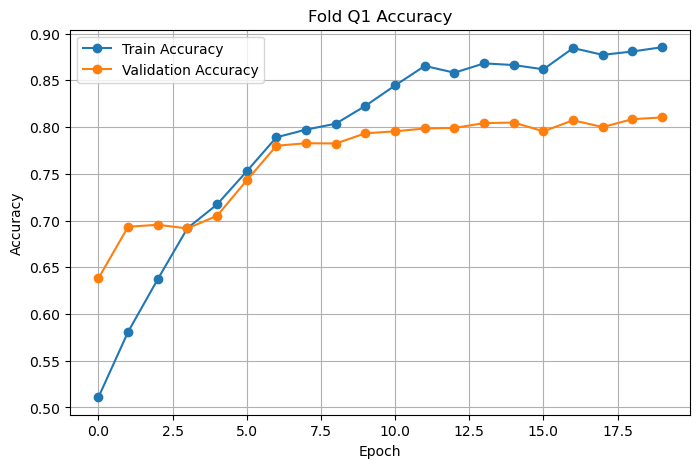

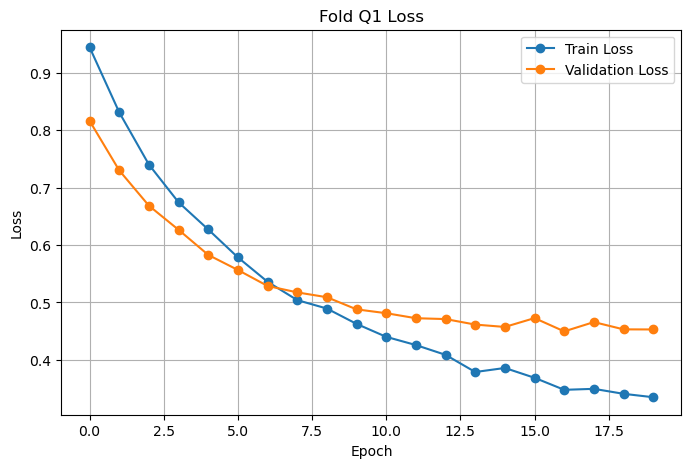

Saved model: vgg16_fold_Q1.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 519s 5s/step


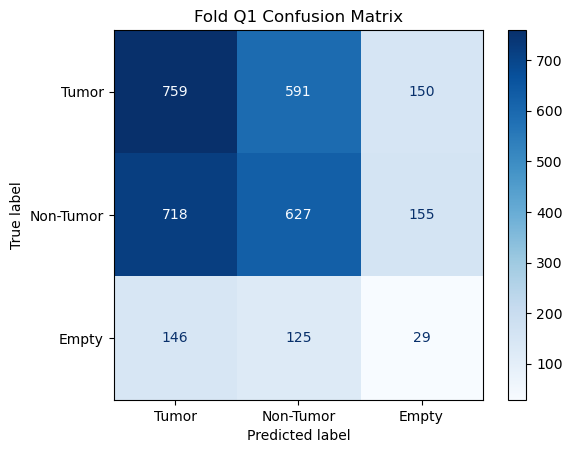

Fold Q1 Accuracy: 0.4288, F1 Score: 0.3395
Classification Report for Fold Q1:
              precision    recall  f1-score   support

       Tumor     0.4677    0.5060    0.4861      1500
   Non-Tumor     0.4669    0.4180    0.4411      1500
       Empty     0.0868    0.0967    0.0915       300

    accuracy                         0.4288      3300
   macro avg     0.3404    0.3402    0.3395      3300
weighted avg     0.4327    0.4288    0.4298      3300

Average 4-Fold Test Accuracy: 0.4288
Average 4-Fold Test Accuracy: 0.3395


In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Prepare ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

quadrant_dfs = {
    "Q1": df_q1,
    "Q2": df_q2,
    "Q3": df_q3,
    "Q4": df_q4
}

# Store results
fold_accuracies = []
fold_f1_scores = []
fold_reports = []
models = {}

for quadrant in ["Q1"]:
    print(f"Starting Fold: Test on {quadrant}")

    # Split
    train_df = quadrant_dfs[quadrant]
    val_quads = [q for q in quadrant_dfs if q != quadrant]
    val_df = pd.concat([quadrant_dfs[q] for q in val_quads], ignore_index=True)

    # # Further split train/val internally
    # train_df, val_df = train_test_split(
    #     train_val_df, 
    #     test_size=0.2, 
    #     stratify=train_val_df['label'], 
    #     random_state=3888
    # )

    # Data Generators
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # test_gen = val_test_datagen.flow_from_dataframe(
    #     test_df,
    #     x_col='Path',
    #     y_col='label',
    #     target_size=(224, 224),
    #     batch_size=32,
    #     class_mode='binary',
    #     shuffle=False
    # )

    # Build Model
    model = build_vgg16_model()

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate

    # --- Plot training curves ---
    
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Fold {quadrant} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Fold {quadrant} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # --- Save model ---
    model.save(f"vgg16_fold_{quadrant}.h5")
    
    models[quadrant] = model
    
    print(f"Saved model: vgg16_fold_{quadrant}.h5")
    
    # --- Confusion Matrix on Val Set ---
    val_gen.reset()
    y_true = val_gen.classes
    y_pred_probs = model.predict(val_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Non-Tumor", "Empty"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {quadrant} Confusion Matrix')
    plt.show()

    acc = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Fold {quadrant} Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    # --- Classification Report ---
    report = classification_report(
    y_true, 
    y_pred, 
    target_names=["Tumor", "Non-Tumor", "Empty"],
    digits=4
    )
    fold_reports.append(report)
    print(f"Classification Report for Fold {quadrant}:\n{report}")

# Final report
mean_acc = np.mean(fold_accuracies)
mean_f1 = np.mean(fold_f1_scores)
print(f"Average 4-Fold Test Accuracy: {mean_acc:.4f}")
print(f"Average 4-Fold Test f1: {mean_f1:.4f}")


In [116]:
print(f"Accuracy of Model using Q1: {fold_accuracies[0]}")
print(f"F1 Score of Model using Q1: {fold_f1_scores[0]}")
# print(f"Accuracy of Model using Q2: {fold_accuracies[1]}")
# print(f"Accuracy of Model using Q3: {fold_accuracies[2]}")
# print(f"Accuracy of Model using Q4: {fold_accuracies[3]}")

Accuracy of Model using Q1: 0.4287878787878788
F1 Score of Model using Q1: 0.3395456993273604


In [ ]:
folds = ["Q1", "Q2", "Q3", "Q4"] 

x = np.arange(len(folds))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 5))

rects1 = ax.bar(x - width/2, fold_accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, fold_f1_scores, width, label='F1 Score', color='lightcoral')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_xlabel('Fold (Quadrant)')
ax.set_title('Model Accuracy and F1 Score Across Folds')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import pandas as pd
from PIL import Image
import matplotlib.patches as patches
from tensorflow.keras.applications.vgg16 import preprocess_input
import seaborn as sns

Image.MAX_IMAGE_PIXELS = None

# CONFIG
IMAGE_SIZE = (224, 224)
PATCH_SIZE = 224  # should match IMAGE_SIZE
STRIDE = 224  # adjust stride for overlapping or non-overlapping
CLASS_COLORS = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}
COLOR_MAP = {0: 'blue', 1: 'green', 2: 'red'}

# Load the big image
big_img = Image.open('BigImage.tif').convert('RGB')
big_arr = np.array(big_img)
h, w, _ = big_arr.shape

# model_input = preprocess_input  

# Load best-performing model
# folds = ["Q1", "Q2", "Q3", "Q4"]
# best_fold = folds[np.argmax(fold_f1_scores)]
best_fold = "Q1"
best_model_path = f"vgg16_fold_{best_fold}.h5"
model = tf.keras.models.load_model(best_model_path)
print(f"Using best model from fold {best_fold}")

# ---------------- HEATMAP INFERENCE ----------------
heatmap = np.zeros((h // STRIDE, w // STRIDE), dtype=int)

for i_idx, i in enumerate(range(0, h - PATCH_SIZE + 1, STRIDE)):
    for j_idx, j in enumerate(range(0, w - PATCH_SIZE + 1, STRIDE)):
        patch = big_arr[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        patch_resized = cv2.resize(patch, IMAGE_SIZE).astype(np.float32)
        patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0))  # for VGG16
        pred = model.predict(patch_input, verbose=0)
        label = np.argmax(pred)
        heatmap[i_idx, j_idx] = label

# ---------------- PLOT HEATMAP ----------------
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
            xticklabels=False, yticklabels=False)
plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(CLASS_LABELS)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
            xticklabels=False, yticklabels=False)
plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(cell_types)
plt.tight_layout()
plt.show()

In [ ]:
df = df_final
tumor_coords = []

for col in df.columns:
    if 'x' in col:
        y_col = col.replace('x', 'y')
        xs = df[col].dropna()
        ys = df[y_col].dropna()
        tumor_coords.extend(zip(xs.astype(int), ys.astype(int)))

# Build ground truth grid
gt_map = np.zeros_like(heatmap)

for x, y in tumor_coords:
    if x < w and y < h:
        i = y // STRIDE
        j = x // STRIDE
        if i < gt_map.shape[0] and j < gt_map.shape[1]:
            gt_map[i, j] = 2  # mark as tumor

# Plot heatmap with overlay
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Prediction Heatmap with Ground Truth Overlay')

# Overlay ground truth (tumor) cells
for i in range(gt_map.shape[0]):
    for j in range(gt_map.shape[1]):
        if gt_map[i, j] == 2:
            plt.gca().add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='yellow', fill=False, linewidth=1))

plt.show()